# Hub'Eau time series univariate forecasting

Setup our working environment first in order to be able to visualise data and make training/prediction:

In [7]:
import sys
sys.path.append('..')

# This ensures that modules are reloaded while developing
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Describe input data and what to predict
timestep = 30 # in minutes, can be 10, 30 or 60
history_range = 12 # N hours history
future_range = 4 # To predict N hours ahead

# Used for model fitting
inputs = 16
model_type = 'GRU' # Underlying Keras model, e.g. SimpleRNN, LSTM, GRU, ...
bidirectional = False # Train also on a reversed copy of the input ?
stacked = True # Stack two models to handle more complex features ?
dropout = 0
batch_size = 128
buffer_size = 512
epochs = 10
steps_per_epoch = 100
validation_steps = 50

In [3]:
# Compute derived parameters (required to be in a separated cell due to how papermill works)
perHour = round(60 / timestep) # number of observation per hour
history = (history_range * perHour) # N time steps for history
future = (future_range * perHour) # N time steps ahead for future

## Data processing

Read raw data from a station to be used for training the model and display it:

Text(0, 0.5, 'Water level (mm)')

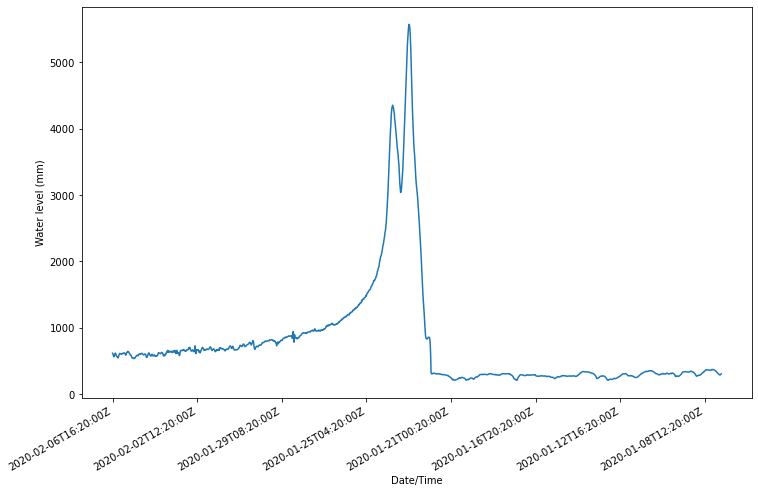

In [8]:
from src.data import read_raw_data

data = read_raw_data("../data/raw/train_data/hubeau_site_Y1422030_30d_" + str(timestep) + "m_L'Aude.csv")
data.plot(subplots=True)
plt.xlabel("Date/Time")
plt.ylabel("Water level (mm)")

Read data from a station at a different time period to be used for validating the model and display it:

Text(0, 0.5, 'Water level (mm)')

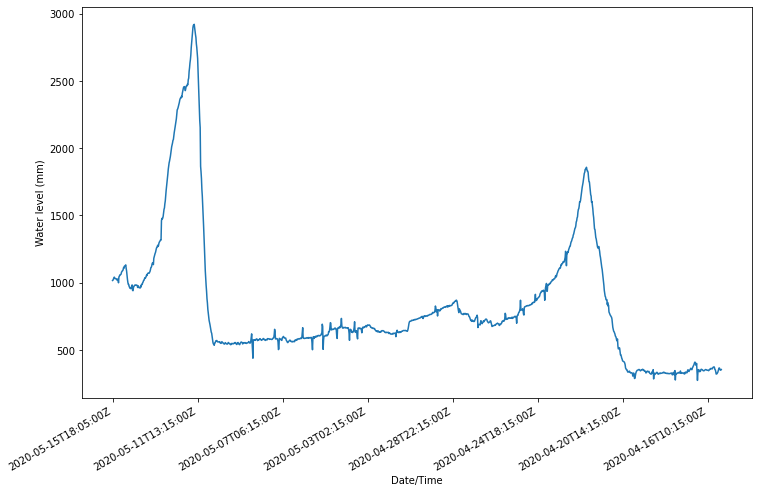

In [9]:
validation_data = read_raw_data("../data/raw/validation_data/hubeau_site_Y1422030_2020-04-15_30d_" + str(timestep) + "m_L'Aude.csv")
validation_data.plot(subplots=True)
plt.xlabel("Date/Time")
plt.ylabel("Water level (mm)")

We will work with two setups:
* a **single-step** setup where the model learns to predict a single point in the future based on some history provided
* a **multi-step** setup where given a past history the model needs to learn to predict a range of future values 

Let's say you want to predict the water level 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 240 (5x48) observations to train the model if your time step is 30 minutes (2 observations per hour). Many such configurations are possible, making this dataset a good one to experiment with.

The `data_windows` function returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict, ie the label(s) that needs to be predicted: a single value for single-step setup and a set of values for multi-step setup.

We can keep 75% of the training dataset to train and the remaining 25% would be the validation data. However, we prefer to use two really different datasets in order to ensure our model is generalizing correctly to unseen data. We split our validation dataset into two parts, 50% for training validation and 50% we will use to test the model against unseen data.

First we need to standardize the data (i.e. transform data to have a mean of zero and a standard deviation of 1):

In [11]:
from src.data import normalize, denormalize

print('Training dataset length is {}'.format(data.size))
mean = data.values.mean()
std = data.values.std()
print ('Training Mean value {} - Std value {}'.format(mean, std))
ndata = normalize(data.values, mean, std)

print('Validation dataset length is {}'.format(validation_data.size))
vmean = validation_data.values.mean()
vstd = validation_data.values.std()
print ('Validation Mean value {} - Std value {}'.format(vmean, vstd))
nvdata = normalize(validation_data.values, mean, std)

Training dataset length is 1440
Training Mean value 764.8993055555555 - Std value 867.8262052389971
Validation dataset length is 1432
Validation Mean value 822.6382681564246 - Std value 491.7656981039218


## Single-step model

We first start with the single step setup: the model learns to predict a single point in the future based on some history provided. Let's now create the data for the model, it will be given the last N recorded observations (eg 24 observations - 12H if your time step is 30 minutes), and needs to learn to predict the level in Y hours (eg 8 observations - 4H ahead if your time step is 30 minutes).

Timestep 30m - History 12h - Looking 240m ahead
Sample window [-0.17272964 -0.18540499 -0.21075568 -0.23149716 -0.22919256 -0.20499416
 -0.17157733 -0.17157733 -0.19692803 -0.20729877 -0.22804025 -0.23495408
 -0.2395633  -0.25339095 -0.23495408 -0.21075568 -0.18655729 -0.17618655
 -0.18079577 -0.18194807 -0.18540499 -0.19116651 -0.18540499 -0.17964346]
Target level value -0.19692803066310993


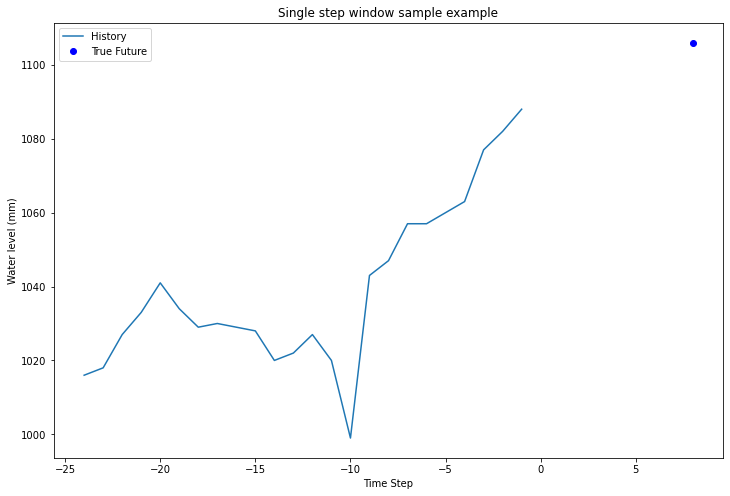

In [12]:
from src.data import data_windows
from src.visualisation import show_single_plot

print ('Timestep {}m - History {}h - Looking {}m ahead'.format(timestep, round(history / perHour), future*timestep))

x_train_single, y_train_single = data_windows(ndata, history, future, single_step=True)
x_validate_single, y_validate_single = data_windows(nvdata, history, future, single_step=True)

print ('Sample window {}'.format(x_train_single[0].flatten()))
print ('Target level value {}'.format(y_train_single[0]))

show_single_plot(x_validate_single[0], y_validate_single[0], future, None, 'Single step window sample example', mean, std)

### Model fitting

In [5]:
# Load model if already fitted, skip otherwise
#model_single = tf.keras.models.load_model("../models/model_single")

We will fit a Recurrent Neural Network (RNN), which is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. In this experiment, we will use a specialized RNN layer called Long Short Term Memory (LSTM).

In [72]:
from src.modelling import fitRNN

(model_single, model_single_history) = fitRNN(x_train_single, y_train_single, x_validate_single, y_validate_single,
                                              inputs, 1, model_type, bidirectional, stacked, dropout,
                                              batch_size, buffer_size, epochs, steps_per_epoch, validation_steps)

Epoch 1/10
100/100 [==============================] - 3s 28ms/step - loss: 0.2868 - mse: 0.4640 - val_loss: 0.0774 - val_mse: 0.0358
Epoch 2/10
100/100 [==============================] - 2s 21ms/step - loss: 0.1006 - mse: 0.0947 - val_loss: 0.0723 - val_mse: 0.0337
Epoch 3/10
100/100 [==============================] - 2s 21ms/step - loss: 0.0955 - mse: 0.0876 - val_loss: 0.0750 - val_mse: 0.0366
Epoch 4/10
100/100 [==============================] - 2s 21ms/step - loss: 0.0921 - mse: 0.0823 - val_loss: 0.0812 - val_mse: 0.0406
Epoch 5/10
100/100 [==============================] - 2s 20ms/step - loss: 0.0911 - mse: 0.0782 - val_loss: 0.0724 - val_mse: 0.0321
Epoch 6/10
100/100 [==============================] - 2s 20ms/step - loss: 0.0857 - mse: 0.0757 - val_loss: 0.0736 - val_mse: 0.0332
Epoch 7/10
100/100 [==============================] - 2s 20ms/step - loss: 0.0813 - mse: 0.0717 - val_loss: 0.0698 - val_mse: 0.0275
Epoch 8/10
100/100 [==============================] - 2s 21ms/step - 

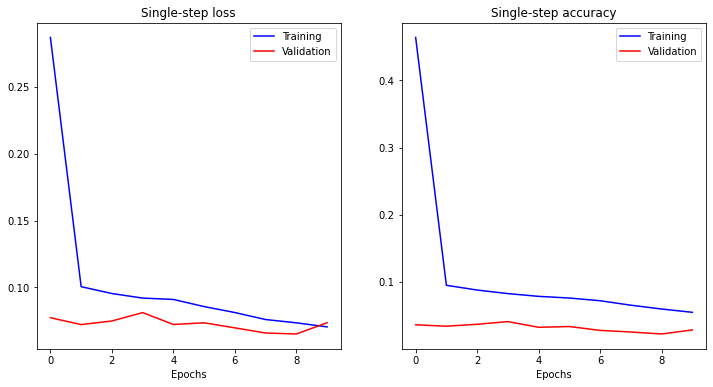

In [73]:
import matplotlib.pyplot as plt
from src.visualisation import plot_train_metric

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_train_metric(model_single_history, 'Single-step loss', 'loss')
plt.subplot(122)
plot_train_metric(model_single_history, 'Single-step accuracy', 'mse')

In Keras the loss is calculated as a moving average over all processed batches, meaning that in the early training stage when loss drops quickly the first batch of an epoch will have a much higher loss than the last. When the epoch is finished, the shown training loss will NOT represent the training loss at the end of the epoch but the average training loss from start to end of the epoch. Therefore, it's often times higher than the validation loss, which is calculated at the end of the epoch entirely.

Fundamental rules:
- validation loss >> training loss => overfitting.
- validation loss  > training loss => some overfitting.
- validation loss  < training loss => some underfitting.
- validation loss << training loss => it underfitting.

Model is fitting very nicely the training data but not at all the validation data when overfitting occurs, in other words it's not generalizing correctly to unseen data. If both losses end up to be roughly the same, and if the values are converging, then chances are very high that we are doing it right.

### Model evaluation

Now see how it performs globally on a flood period:

Mean Absolute Error 28.67
Max Absolute Error 64.28
Mean Absolute Percentage Error 2.33%
Max Absolute Percentage Error 16.52%
Mean Squared Error 3612.38
Root Mean Squared Error 60.10


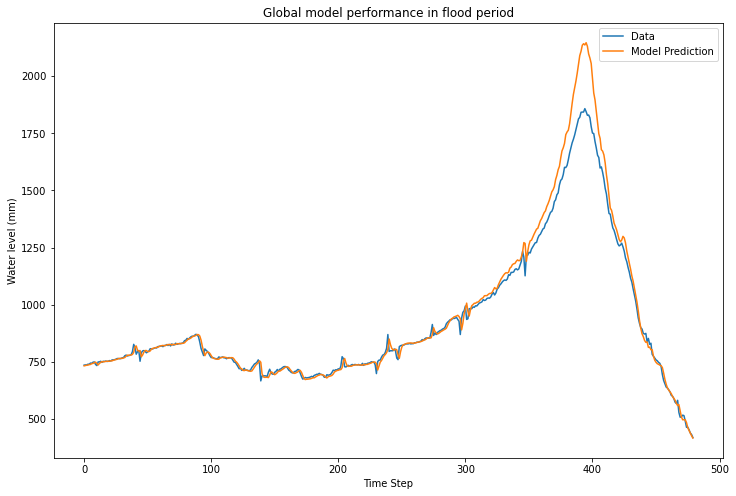

In [13]:
from src.modelling import predictRangeRNN
from src.visualisation import show_prediction

flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predictRangeRNN(model_single, validation_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance in flood period')

Then see how it performs globally on another station:

Mean Absolute Error 312.22
Max Absolute Error 1619.58
Mean Absolute Percentage Error 13.67%
Max Absolute Percentage Error 61.74%
Mean Squared Error 224155.79
Root Mean Squared Error 473.45


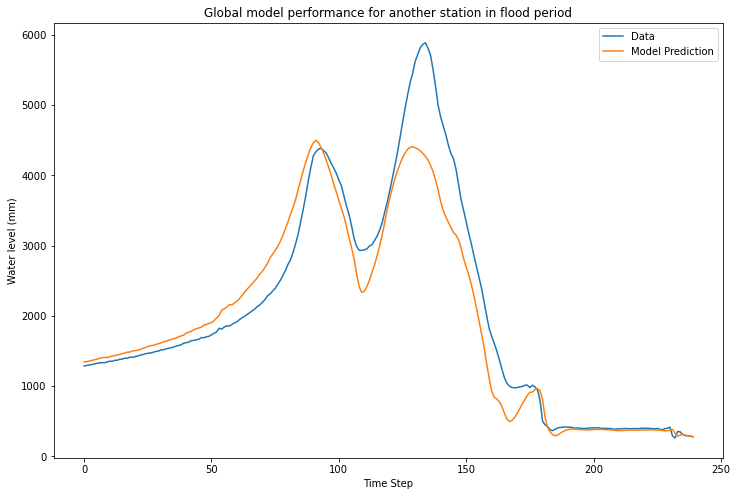

In [20]:
# Data for testing at another but near station
test_data = read_raw_data("../data/raw/train_data/hubeau_site_Y1232010_30d_" + str(timestep) + "m_L'Aude.csv")

flood_start = 12 * 24 * perHour # 12 days after start period
flood_end = 17 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_single, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another station in flood period')

And another period:

Mean Absolute Error 29.26
Max Absolute Error 22.07
Mean Absolute Percentage Error 2.20%
Max Absolute Percentage Error 19.48%
Mean Squared Error 4392.84
Root Mean Squared Error 66.28


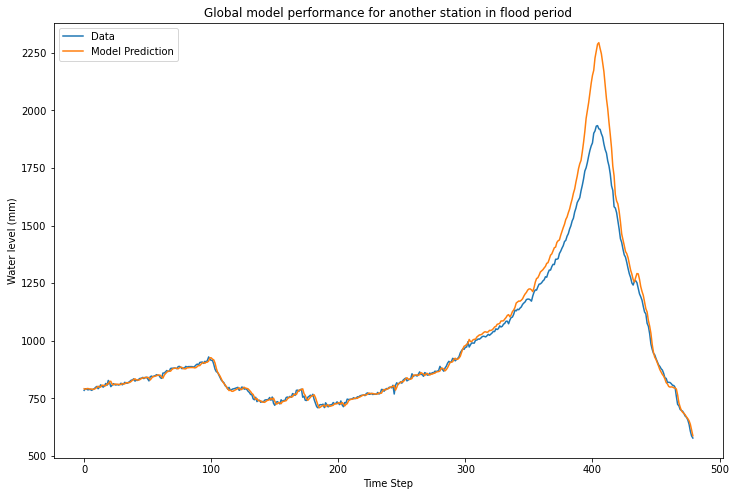

In [21]:
# Data for testing at another but near station
test_data = read_raw_data("../data/raw/validation_data/hubeau_site_Y1232010_2020-04-15_30d_" + str(timestep) + "m_L'Aude.csv")

flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predictRangeRNN(model_single, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another station in flood period')

## Multi-step model

We will then work with the multi-step setup, ie given a past history, the model needs to learn to predict a range of future values. Data setup and model training is pretty similar except since the task here is a bit more complicated than the previous task, the model can consist of more LSTM layers.

Sample window [-0.17272964 -0.18540499 -0.21075568 -0.23149716 -0.22919256 -0.20499416
 -0.17157733 -0.17157733 -0.19692803 -0.20729877 -0.22804025 -0.23495408
 -0.2395633  -0.25339095 -0.23495408 -0.21075568 -0.18655729 -0.17618655
 -0.18079577 -0.18194807 -0.18540499 -0.19116651 -0.18540499 -0.17964346]
Target level value [-0.17964346 -0.17042503 -0.16927272 -0.1635112  -0.17042503 -0.17618655
 -0.18310038 -0.20729877]


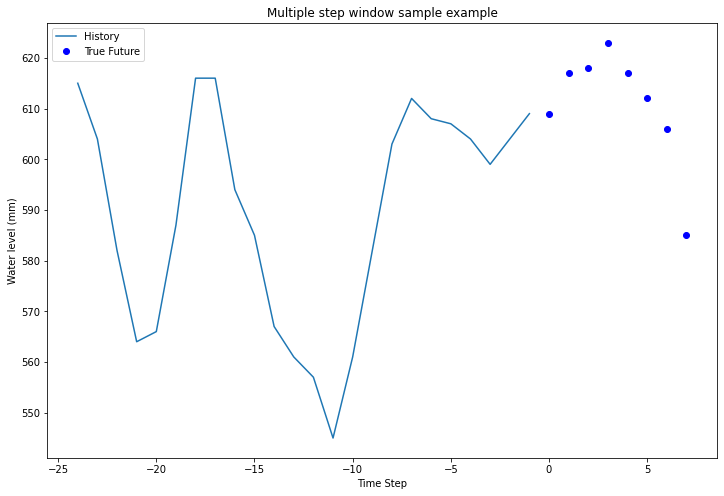

In [17]:
from src.visualisation import show_multiple_plot

x_train_multiple, y_train_multiple = data_windows(ndata, history, future, single_step=False)
x_validate_multiple, y_validate_multiple = data_windows(nvdata, history, future, single_step=False)

print ('Sample window {}'.format(x_train_multiple[0].flatten()))
print ('Target level value {}'.format(y_train_multiple[0]))

show_multiple_plot(x_train_multiple[0], y_train_multiple[0], None, 'Multiple step window sample example', mean, std)

### Model fitting

In [4]:
# Load model if already fitted, skip otherwise
#model_multiple = tf.keras.models.load_model("../models/model_multiple")

In [69]:
from src.modelling import fitRNN

(model_multiple, model_multiple_history) = fitRNN(x_train_multiple, y_train_multiple, x_validate_multiple, y_validate_multiple,
                                                  inputs, future, model_type, bidirectional, stacked, dropout,
                                                  batch_size, buffer_size, epochs, steps_per_epoch, validation_steps)

Epoch 1/10
100/100 [==============================] - 3s 32ms/step - loss: 0.3941 - mse: 0.6676 - val_loss: 0.1141 - val_mse: 0.0566
Epoch 2/10
100/100 [==============================] - 2s 21ms/step - loss: 0.0956 - mse: 0.0857 - val_loss: 0.0603 - val_mse: 0.0212
Epoch 3/10
100/100 [==============================] - 2s 21ms/step - loss: 0.0725 - mse: 0.0526 - val_loss: 0.0514 - val_mse: 0.0167
Epoch 4/10
100/100 [==============================] - 2s 21ms/step - loss: 0.0673 - mse: 0.0457 - val_loss: 0.0498 - val_mse: 0.0165
Epoch 5/10
100/100 [==============================] - 2s 21ms/step - loss: 0.0636 - mse: 0.0409 - val_loss: 0.0489 - val_mse: 0.0158
Epoch 6/10
100/100 [==============================] - 2s 22ms/step - loss: 0.0599 - mse: 0.0367 - val_loss: 0.0420 - val_mse: 0.0113
Epoch 7/10
100/100 [==============================] - 2s 20ms/step - loss: 0.0571 - mse: 0.0329 - val_loss: 0.0385 - val_mse: 0.0094
Epoch 8/10
100/100 [==============================] - 2s 21ms/step - 

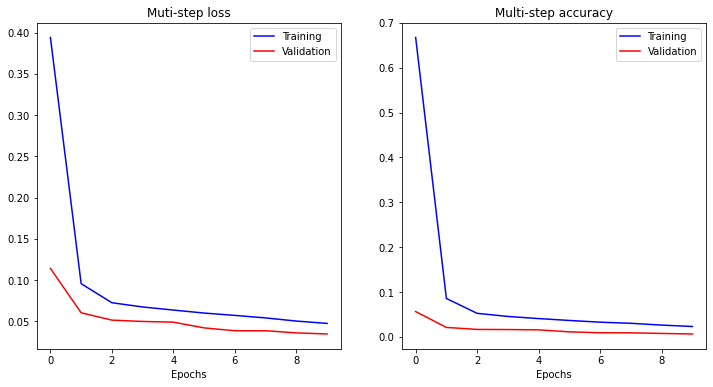

In [70]:
from src.visualisation import plot_train_metric

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_train_metric(model_multiple_history, 'Muti-step loss', 'loss')
plt.subplot(122)
plot_train_metric(model_multiple_history, 'Multi-step accuracy', 'mse')

### Model evaluation

Now see how it performs globally on a flood period:

Mean Absolute Error 14.29
Max Absolute Error 70.15
Mean Absolute Percentage Error 1.51%
Max Absolute Percentage Error 11.33%
Mean Squared Error 404.30
Root Mean Squared Error 20.11


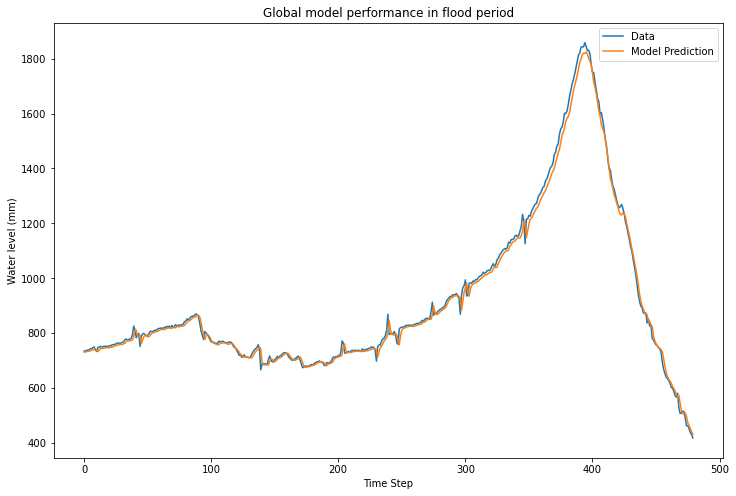

In [18]:
from src.modelling import predictRangeRNN

flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predictRangeRNN(model_multiple, validation_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance in flood period')

Then see how it performs globally on another station:

Mean Absolute Error 79.70
Max Absolute Error 451.79
Mean Absolute Percentage Error 4.13%
Max Absolute Percentage Error 67.41%
Mean Squared Error 15225.01
Root Mean Squared Error 123.39


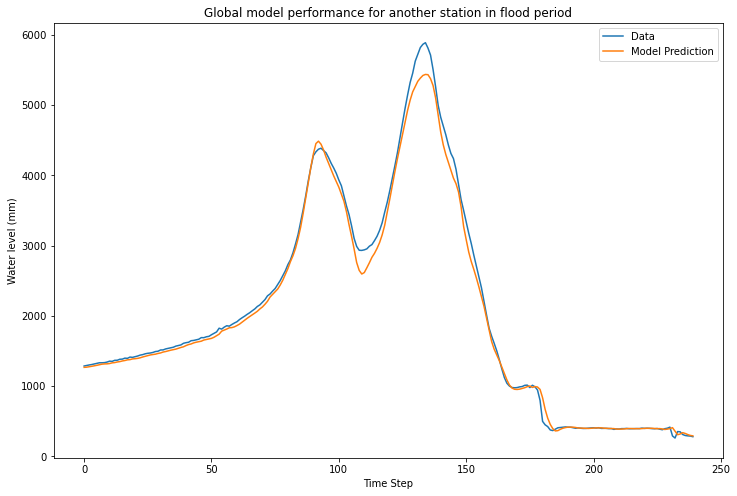

In [22]:
# Data for testing at another but near station
test_data = read_raw_data("../data/raw/train_data/hubeau_site_Y1232010_30d_" + str(timestep) + "m_L'Aude.csv")

flood_start = 12 * 24 * perHour # 12 days after start period
flood_end = 17 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_multiple, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another station in flood period')

And another period:

Mean Absolute Error 12.62
Max Absolute Error 63.26
Mean Absolute Percentage Error 1.23%
Max Absolute Percentage Error 5.84%
Mean Squared Error 291.66
Root Mean Squared Error 17.08


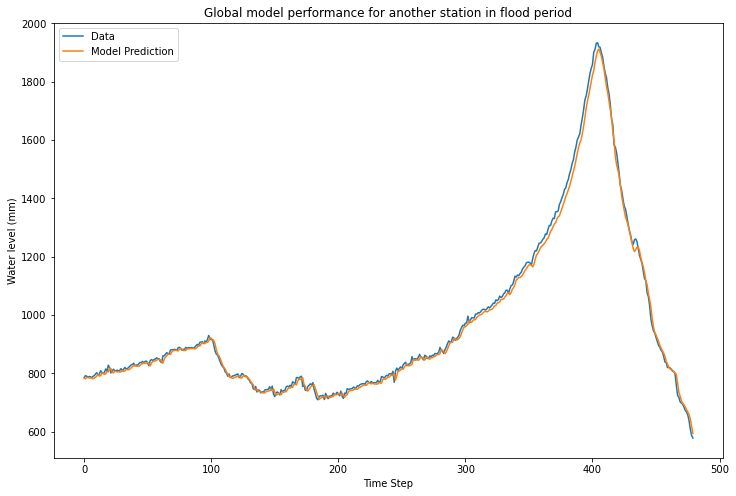

In [23]:
# Data for testing at another but near station
test_data = read_raw_data("../data/raw/validation_data/hubeau_site_Y1232010_2020-04-15_30d_" + str(timestep) + "m_L'Aude.csv")

flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predictRangeRNN(model_multiple, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another station in flood period')

In [79]:
# Save models if we are happy with
#model_single.save("../models/model_single")
#model_multiple.save("../models/model_multiple")

INFO:tensorflow:Assets written to: ../models/model_single\assets
INFO:tensorflow:Assets written to: ../models/model_multiple\assets
